In [63]:
import pandas as pd
import numpy as np
import math as maths
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [64]:
usecolsResult = ["eventType", "keyValue", "x", "y", "offsetX", "offsetY", "keyCenterX", "keyCenterY", "holdTime", "flightTime", "pressure"]
usecolsTarget = ["eventType",  "keyValue", "offsetX", "offsetY", "keyCenterX", "keyCenterY", "holdTime", "flightTime", "pressure"]

path_ = "C:/Users/mathi/OneDrive/Bachelor Stuff/Hauptstudie/Pilot/KeyStrokeLog/"
path = "E:/OneDrive/Bachelor Stuff/Hauptstudie/Pilot/KeyStrokeLog/"
targetGroupPath = path + "ID_targetValues/"

pidList = os.listdir(path)
pidList.remove("ID_targetValues")
pidList.remove("read csv.py")
pidList.remove("read csv - Kopie.py")

values = []

#One iteration = one Participant
for pid in pidList:
	# Build filepaths for all tasks for current pid
	taskGroupPath = path + pid + "/"
	taskGroupList = os.listdir(taskGroupPath)
	taskPathDict = {}
	targetPathDict = {}
	for taskGroup in taskGroupList:
		# Filter out user created tasks
		if taskGroup != "17_user-created password":
			taskDirs = [task  for task in sorted(os.listdir(taskGroupPath + taskGroup))]
			taskPathDict[taskGroup] = [(taskGroup + "/" + taskDir)  for taskDir in taskDirs if not taskDir == "17_user-created password"]
			targetPathDict[taskGroup] = [(taskGroup + "/" + taskDir)  for taskDir in taskDirs if not taskDir == "17_user-created password"]
			
	# One iteration = one taskgroup
	for key in sorted(taskPathDict.keys()):
		#One iteration = one task (3 csv files per task)
		for task in sorted(taskPathDict[key]):
			# last 3 csv files in <task> read as a list of dataframes
			taskResultList = [pd.read_csv(taskGroupPath + task + "/" + entry, sep=';', header=0, usecols=usecolsResult) for entry in [taskEntry for taskEntry in sorted(os.listdir(taskGroupPath + task), reverse=True) if taskEntry.startswith('valid')][:3]]
			# target df for that specific result
			targetDf = pd.read_csv(targetGroupPath + task + "/" + os.listdir(targetGroupPath + task)[0], sep=';', header=0, usecols=usecolsTarget)
			targetDf = targetDf.add_prefix('target_')
			# Combine resultDataframes with target DF (horizontally)
			for resultDf in taskResultList:
				resultAndTargetTempDF = pd.concat([resultDf, targetDf], axis = 1)
				resultAndTargetTempDF["task"] = task[-2:]
 				resultAndTargetTempDF["pId"] = pid
				values.append(resultAndTargetTempDF)
	print "Finished " + pid
masterDF = pd.concat(values, axis=0)
masterDF['area_error'] = masterDF.apply(lambda row: np.absolute(row['pressure'] - row['target_pressure']), axis=1)
masterDF['htime_error'] = masterDF.apply(lambda row: np.absolute(row['holdTime'] - row['target_holdTime']), axis=1)
masterDF['ftime_error'] = masterDF.apply(lambda row: np.absolute(row['flightTime'] - row['target_flightTime']), axis=1)
masterDF['offset_error'] = masterDF.apply(lambda row: maths.hypot(row['offsetX'] - row['target_offsetX'], row['offsetY'] - row['target_offsetY']), axis=1)
print "Finished concat"

Finished ID_0
Finished ID_1
Finished ID_2
Finished concat


In [65]:
# Error Dataframes
defaultAreaError = masterDF[(masterDF['eventType'] == "up") & (masterDF['target_pressure'] == 0.2)][['area_error', 'task', 'pId']]
bigAreaError = masterDF[(masterDF['eventType'] == "up") & (masterDF['target_pressure'] == 0.45)][['area_error', 'task', 'pId']]

defaultHoldTimeError = masterDF[(masterDF['target_holdTime'] == 80)][['htime_error', 'task', 'pId']]
longHoldTimeError = masterDF[(masterDF['target_holdTime'] == 300)][['htime_error', 'task', 'pId']]

defaultFlightTimeError = masterDF[(masterDF['target_flightTime'] == 260)][['ftime_error', 'task', 'pId']]
longFlightTimeError = masterDF[(masterDF['target_flightTime'] == 1000)][['ftime_error', 'task', 'pId']]

centerOffsetError = masterDF[(masterDF['target_offsetX'] == 0) & (masterDF['target_offsetY'] == 0)][['offset_error', 'task', 'pId']]
leftOffsetError = masterDF[(masterDF['target_offsetX'] == -45) & (masterDF['target_offsetY'] == 0)][['offset_error', 'task', 'pId']]
rightOffsetError = masterDF[(masterDF['target_offsetX'] == 45) & (masterDF['target_offsetY'] == 0)][['offset_error', 'task', 'pId']]
topOffsetError = masterDF[(masterDF['target_offsetX'] == 0) & (masterDF['target_offsetY'] == -80)][['offset_error', 'task', 'pId']]
bottomOffsetError = masterDF[(masterDF['target_offsetX'] == 0) & (masterDF['target_offsetY'] == 80)][['offset_error', 'task', 'pId']]

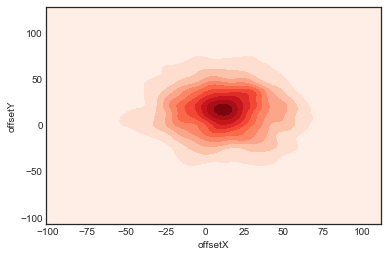

In [120]:
# Center offset contour plot
offsets = masterDF[(masterDF['target_offsetX'] == 0) & (masterDF['target_offsetY'] == 0)][["offsetX", "offsetY", 'task', 'pId']]
 
sns.kdeplot(offsets['offsetX'], offsets['offsetY'], cmap="Reds", shade=True, bw=5)

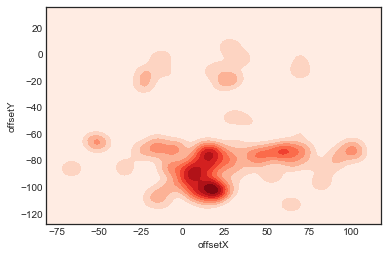

In [121]:
# Bottom offset contour plot
offsets = masterDF[(masterDF['target_offsetX'] == 0) & (masterDF['target_offsetY'] == 80)][["offsetX", "offsetY", 'task', 'pId']]
offsets['offsetY'] = offsets.apply(lambda row: row['offsetY'] * (-1), axis=1)
sns.kdeplot(offsets['offsetX'], offsets['offsetY'], cmap="Reds", shade=True, bw=5)

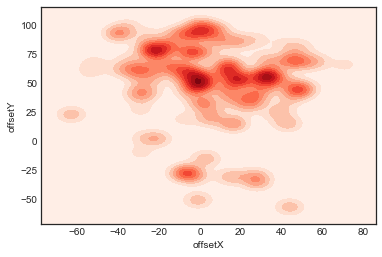

In [122]:
# Top offset contour plot
offsets = masterDF[(masterDF['target_offsetX'] == 0) & (masterDF['target_offsetY'] == -80)][["offsetX", "offsetY", 'task', 'pId']]
offsets['offsetY'] = offsets.apply(lambda row: row['offsetY'] * (-1), axis=1)
sns.kdeplot(offsets['offsetX'], offsets['offsetY'], cmap="Reds", shade=True, bw=5)

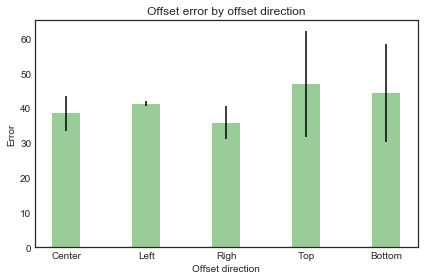

In [123]:
# Offset Error
meanCenterOffsetError = centerOffsetError['offset_error'].mean()
meanLeftOffsetError = leftOffsetError['offset_error'].mean()
meanRightOffsetError = rightOffsetError['offset_error'].mean()
meanTopOffsetError = topOffsetError['offset_error'].mean()
meanBottomOffsetError = bottomOffsetError['offset_error'].mean()

pCenterOffsetStd = centerOffsetError.groupby('pId')['offset_error'].mean().std()
pLeftOffsetStd = leftOffsetError.groupby('pId')['offset_error'].mean().std()
pRightOffsetStd = rightOffsetError.groupby('pId')['offset_error'].mean().std()
pTopOffsetStd = topOffsetError.groupby('pId')['offset_error'].mean().std()
pBottomOffsetStd = bottomOffsetError.groupby('pId')['offset_error'].mean().std()

offset_means = (meanCenterOffsetError, meanLeftOffsetError, meanRightOffsetError, meanTopOffsetError, meanBottomOffsetError)
offset_stds = (pCenterOffsetStd, pLeftOffsetStd, pRightOffsetStd, pTopOffsetStd, pBottomOffsetStd)

fig, ax = plt.subplots()

index = np.arange(len(offset_means))
bar_width = 0.35

opacity = 0.4

rects = ax.bar(index, offset_means, bar_width, 
               alpha=opacity, color='g', yerr=offset_stds)

ax.set_xlabel('Offset direction')
ax.set_ylabel('Error')
ax.set_title('Offset error by offset direction')
ax.set_xticks(index)
ax.set_xticklabels(('Center', 'Left', 'Righ', 'Top', 'Bottom'))
ax.legend()

fig.tight_layout()
plt.show()

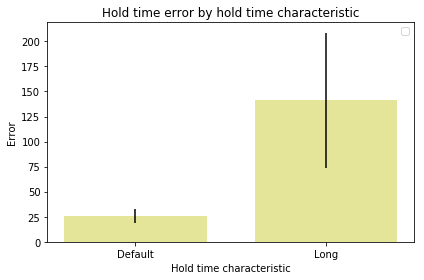

In [50]:
# Hold time Error
meanDefaultHoldTimeError = defaultHoldTimeError['htime_error'].mean()
meanLongHoldTimeError = longHoldTimeError['htime_error'].mean()

pDefaultHoldTimeErrorStd = defaultHoldTimeError.groupby('pId')['htime_error'].mean().std()
pLongHoldTimeErrorStd = longHoldTimeError.groupby('pId')['htime_error'].mean().std()

holdtime_means = (meanDefaultHoldTimeError, meanLongHoldTimeError)
holdtime_stds = (pDefaultHoldTimeErrorStd, pLongHoldTimeErrorStd)

fig, ax = plt.subplots()

index = np.arange(len(area_means))
bar_width = 0.75

opacity = 0.4

rects = ax.bar(index, holdtime_means, bar_width, 
               alpha=opacity, color='y', yerr=holdtime_stds)

ax.set_xlabel('Hold time characteristic')
ax.set_ylabel('Error')
ax.set_title('Hold time error by hold time characteristic')
ax.set_xticks(index)
ax.set_xticklabels(('Default', 'Long'))
ax.legend()

fig.tight_layout()
plt.show()

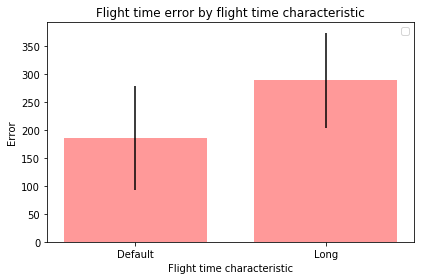

In [53]:
# Flight time Error
meanDefaultFlightTimeError = defaultFlightTimeError['ftime_error'].mean()
meanLongFlightTimeError = longFlightTimeError['ftime_error'].mean()

pDefaultFlightTimeErrorStd = defaultFlightTimeError.groupby('pId')['ftime_error'].mean().std()
pLongFlightTimeErrorStd = longFlightTimeError.groupby('pId')['ftime_error'].mean().std()

flighttime_means = (meanDefaultFlightTimeError, meanLongFlightTimeError)
flighttime_stds = (pDefaultFlightTimeErrorStd, pLongFlightTimeErrorStd)

fig, ax = plt.subplots()

index = np.arange(len(area_means))
bar_width = 0.75

opacity = 0.4

rects = ax.bar(index, flighttime_means, bar_width, 
               alpha=opacity, color='r', yerr=flighttime_stds)

ax.set_xlabel('Flight time characteristic')
ax.set_ylabel('Error')
ax.set_title('Flight time error by flight time characteristic')
ax.set_xticks(index)
ax.set_xticklabels(('Default', 'Long'))
ax.legend()

fig.tight_layout()
plt.show()

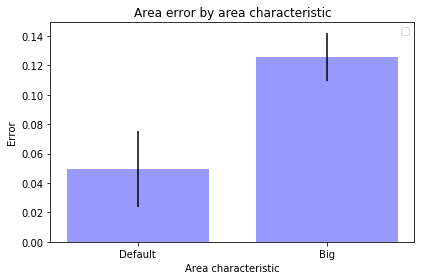

In [51]:
# Area Error
meanDefaultAreaError = defaultAreaError['area_error'].mean()
meanBigAreaError = bigAreaError['area_error'].mean()

pDefaultAreaErrorStd = defaultAreaError.groupby('pId')['area_error'].mean().std()
pBigAreaErrorStd = bigAreaError.groupby('pId')['area_error'].mean().std()

area_means = (meanDefaultAreaError, meanBigAreaError)
area_stds = (pDefaultAreaErrorStd, pBigAreaErrorStd)

fig, ax = plt.subplots()

index = np.arange(len(area_means))
bar_width = 0.75

opacity = 0.4

rects = ax.bar(index, area_means, bar_width, 
               alpha=opacity, color='b', yerr=area_stds)

ax.set_xlabel('Area characteristic')
ax.set_ylabel('Error')
ax.set_title('Area error by area characteristic')
ax.set_xticks(index)
ax.set_xticklabels(('Default', 'Big'))
ax.legend()

fig.tight_layout()
plt.show()

In [3]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(masterDF)

eventType keyValue     x    y  offsetX  offsetY  keyCenterX  keyCenterY  \
0       down        f   578  345        2       -5         576         350   
1         up        f   578  345        2       -5         576         350   
2       down        o  1238  151       14       21        1224         130   
3         up        o  1235  154       11       24        1224         130   
4       down        o  1233  133        9        3        1224         130   
5         up        o  1233  133        9        3        1224         130   
6       down        t   638  156      -10       26         648         130   
7         up        t   638  156      -10       26         648         130   
8       down        b   874  585       10       15         864         570   
9         up        b   874  585       10       15         864         570   
10      down        a   163  352       55        2         108         350   
11        up        a   160  353       52        3         108         350   
12      down        l  1295  332      -37      -18        1332         350   
13        up        l  1292  334      -40      -16        1332         350   
14      down        l  1290  341      -42       -9        1332         350   
15        up        l  1288  342      -44       -8        1332         350   
0       down        f   572  326       -4      -24         576         350   
1         up        f   572  326       -4      -24         576         350   
2       down        o  1237  147       13       17        1224         130   
3         up        o  1233  147        9       17        1224         130   
4       down        o  1235  133       11        3        1224         130   
5         up        o  1230  135        6        5        1224         130   
6       down        t   642  129       -6       -1         648         130   
7         up        t   642  129       -6       -1         648         130   
8       down        b   874  571       10        1         864         570   
9         up        b   874  571       10        1         864         570   
10      down        a   185  343       77       -7         108         350   
11        up        a   183  345       75       -5         108         350   
12      down        l  1298  345      -34       -5        1332         350   
13        up        l  1298  345      -34       -5        1332         350   
14      down        l  1285  350      -47        0        1332         350   
15        up        l  1285  350      -47        0        1332         350   
0       down        f   592  353       16        3         576         350   
1         up        f   589  355       13        5         576         350   
2       down        o  1238  153       14       23        1224         130   
3         up        o  1235  153       11       23        1224         130   
4       down        o  1215  154       -9       24        1224         130   
5         up        o  1215  154       -9       24        1224         130   
6       down        t   641  139       -7        9         648         130   
7         up        t   641  139       -7        9         648         130   
8       down        b   862  584       -2       14         864         570   
9         up        b   862  584       -2       14         864         570   
10      down        a   153  354       45        4         108         350   
11        up        a   150  362       42       12         108         350   
12      down        l  1267  344      -65       -6        1332         350   
13        up        l  1267  344      -65       -6        1332         350   
14      down        l  1277  352      -55        2        1332         350   
15        up        l  1275  354      -57        4        1332         350   
0       down        p  1397  141       29       11        1368         130   
1         up        p  1358  154      -10       24        1368         130   
2       down        a   1

In [19]:
masterDF[(masterDF['eventType'] == " up") & (masterDF['target_pressure'] == 0.2)]["area_error"]

1     0.015686
3     0.019608
5     0.015686
7     0.019608
9     0.023529
11    0.137255
13    0.043137
15    0.023529
1     0.023529
3     0.023529
5     0.023529
7     0.035294
9     0.023529
11    0.015686
13    0.019608
15    0.027451
1     0.019608
3     0.015686
5     0.015686
7     0.023529
9     0.023529
11    0.015686
13    0.035294
15    0.035294
1     0.027451
3     0.015686
5     0.023529
7     0.015686
9     0.011765
11    0.023529
        ...   
5     0.105882
7     0.129412
11    0.015686
13    0.047059
15    0.050980
1     0.027451
3     0.164706
5     0.121569
7     0.160784
11    0.007843
13    0.066667
15    0.062745
1     0.031373
3     0.180392
5     0.243137
7     0.054902
11    0.227451
15    0.270588
1     0.015686
3     0.125490
5     0.227451
7     0.015686
11    0.211765
15    0.231373
1     0.003922
3     0.062745
5     0.094118
7     0.078431
11    0.227451
15    0.254902
Name: area error, Length: 3150, dtype: float64